# Belief Propagation Example

References:
- Alice Gao's Lecture on [Belief Propagation](https://cs.uwaterloo.ca/~a23gao/cs486686_f21/lecture_notes/Lecture_11_on_Independence_and_Bayesian_Networks.pdf)
- Belief propagation example from: https://youtu.be/bFYAxLd5ACo?si=uq-Gqs1X9pMCYJLn
- https://karlstratos.com/notes/graphical_models.pdf
- MIT EECS 6.869 Lecture 7 on [graphical models and belief propagation](http://6.869.csail.mit.edu/fa13/lectures/slideNotesCh7rev.pdf)
- https://cseweb.ucsd.edu/classes/sp06/cse151/lectures/belief-propagation.pdf
- https://www2.cs.arizona.edu/~pachecoj/courses/csc665-1/lectures/marina_bethe.pdf

## Background
Belief propagation is a dynamic programming approach that lets us perform inference on probabilistic graphical models. For any tree-structured graphical model, _e.g._, Markov Random Fields (MRF), factor graphs, belief propagation finds an exact solution on the marginal probalities with a reduced computational complexity. For non-trees, the technique is known instead as _loopy belief propagation_ and is only capable of _approximate_ inference.

The steps involved extends the variable elimination algorithm. Instead of re-calculating the same partial sums for the marginals of different sets of random variables, belief propagation leverages that fact and stores them as _messages_. These _messages_, which indicate the value of a directional edge, are precomputed for the entire graph.

### Inference on a Markov Random Field
Let's see how the belief propagation algorithm arises through solving the inference problem. Consider the following tree-structured MRF.

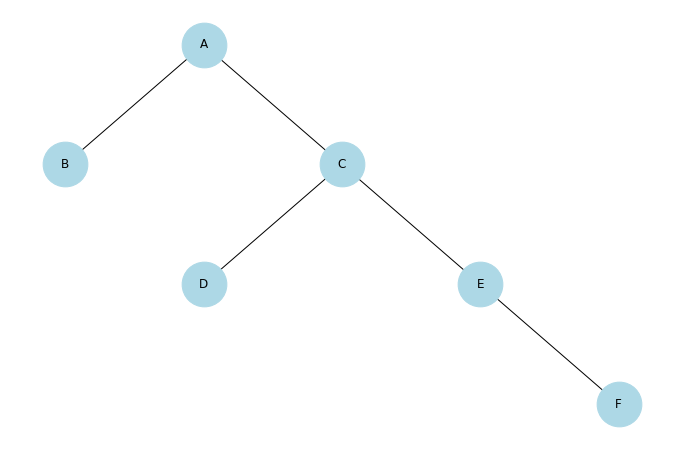

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Define node positions manually
positions = {"A": (0, 2), "B": (-1, 1), "C": (1, 1), "D": (0, 0), "E": (2, 0), "F": (3, -1)}

# Add nodes
G.add_nodes_from(positions)

# Add edges
edges = [("A", "B"), ("A", "C"), ("C", "D"), ("C", "E"), ("E", "F")]
G.add_edges_from(edges)

# Draw the graph
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(G, pos=positions, with_labels=True, node_size=2000, node_color="lightblue", ax=ax)
plt.axis("off")  # Turn off axis labels
plt.show()

#### How does it work?
Inference is typically formulated as follows: given some subset of the graph as evidence nodes (observed variables), we want to compute conditional probabilities on the rest of the graph (hidden variables).

We first start with the general case (without any evidence) by describing the joint probability. Based on the figure above, the joint probability &mdash; in terms of the potentials &mdash; would be
\begin{align*}
    p(A,B,C,D,E,F) &= \frac{1}{Z} \psi_{AB}(A, B) \psi_{AC}(A, C) \psi_{CD}(C, D) \psi_{CE}(C, E) \psi_{EF}(E, F)
\end{align*}
where $Z = \sum_{a,b,c,d,e,f}\psi_{AB}(A, B) \psi_{AC}(A, C) \psi_{CD}(C, D) \psi_{CE}(C, E) \psi_{EF}(E, F)$ is the normalization constant. Note that we make no distinction on the directionality of the potentials: $\psi_{ij} = \psi_{ji}$.

The marginalization of the joint probability &mdash; say, for node A &mdash; is
\begin{align*}
    & & p(A) &= \frac{1}{Z} \sum_{b,c,d,e,f} \psi_{AB}(A, B) \psi_{AC}(A, C) \psi_{CD}(C, D) \psi_{CE}(C, E) \psi_{EF}(E, F) \\
    \text{(partial sums over $b$, $d$, $f$ are independent)} & & &= \frac{1}{Z} \sum_{c, e} \bigg[ \psi_{AC}(A, C) \psi_{CE}(C, E) \bigg( \sum_{b} \psi_{AB}(A, B) \bigg) \bigg( \sum_{d} \psi_{CD}(C, D) \bigg) \bigg( \sum_{f} \psi_{EF}(E, F) \bigg) \bigg] \\
    \text{(convert independent partial sums to messages)} & & &= \frac{1}{Z} \sum_{c, e} \psi_{AC}(A, C) \psi_{CE}(C, E) m_{BA}(A) m_{DC}(C) m_{FE}(E) \\
    \text{(partial sum over $e$ is independent)} & & &= \frac{1}{Z} \sum_{c} \bigg[ \psi_{AC}(A, C) m_{BA}(A) m_{DC}(C) \bigg( \sum_{e} \psi_{CE}(C, E) m_{FE}(E) \bigg) \bigg] \\
    \text{(convert individual partial sums to messages)} & & &= \frac{1}{Z} \sum_{c} \psi_{AC}(A, C) m_{BA}(A) m_{DC}(C) m_{EC}(C) \\
    \text{(partial sum over $c$ is independent from $m_{BA}(A)$)} & & &= \frac{1}{Z} m_{BA}(A) \sum_{c} \psi_{AC}(A, C) m_{DC}(C) m_{EC}(C) \\
    & & &= \frac{1}{Z} m_{BA}(A) m_{CA}(A)
\end{align*}
where we introduce the definition of a _message_ being "passed" between nodes as _a partial sum over the source node variable_ (the following describes a message from node $i$ to $j$):
\begin{align*}
    m_{ij}(j) = \sum_i \psi_{ij}(i,j) \prod_{k \in \mathcal{N}_i \backslash j} m_{ki}(i)
\end{align*}
with $\mathcal{N}_i$ denoting the neighbors of node $i$ and notice that the message argument is always the target node.

The message definition is simply a recursive operation of accumulating (other) messages; a message can be made up of other messages. We show this process using the figure below.

1. Starting from the leaf nodes, the product becomes unity because they have no neighbors besides the destination node. We see this for $m_{BA}$, $m_{EC}$, and $m_{FD}$, where the messages from the leaf nodes $B$, $E$, and $F$ have been collected (in red).
2. Their targets are nodes $A$, $C$, and $D$; focusing our attention on node $D$ we see that the message $m_{DC}$ collects messages that were "passed" to it previously (in blue).
3. Eventually, we have the messages required to compute the message $m_{CA}$ (in green).

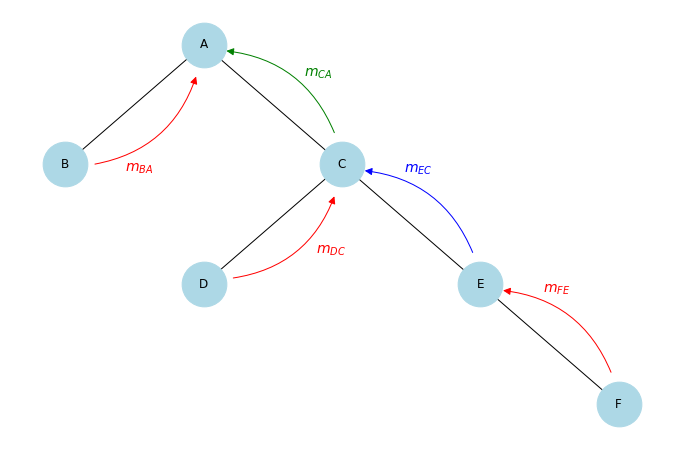

In [2]:
import matplotlib.patches as patches
from matplotlib.text import Text

# Add a curved arrow manually
arrow_start_ba = tuple(i + j for i,j in zip(positions["B"], (0.2, 0)))
arrow_end_ba = tuple(i + j for i,j in zip(positions["A"],(-0.05, -0.25)))
arrow_ba = patches.FancyArrowPatch(arrow_start_ba, arrow_end_ba, arrowstyle='-|>', mutation_scale=15, color='red', connectionstyle="arc3,rad=.3")

arrow_start_ec = tuple(i + j for i,j in zip(positions["E"], (-0.05, 0.25)))
arrow_end_ec = tuple(i + j for i,j in zip(positions["C"],(0.15, -0.05)))
arrow_ec = patches.FancyArrowPatch(arrow_start_ec, arrow_end_ec, arrowstyle='-|>', mutation_scale=15, color='blue', connectionstyle="arc3,rad=.3")

arrow_start_fe = tuple(i + j for i,j in zip(positions["F"], (-0.05, 0.25)))
arrow_end_fe = tuple(i + j for i,j in zip(positions["E"],(0.15, -0.05)))
arrow_fe = patches.FancyArrowPatch(arrow_start_fe, arrow_end_fe, arrowstyle='-|>', mutation_scale=15, color='red', connectionstyle="arc3,rad=.3")

arrow_start_dc = tuple(i + j for i,j in zip(positions["D"], (0.2, 0.05)))
arrow_end_dc = tuple(i + j for i,j in zip(positions["C"],(-0.05, -0.25)))
arrow_dc = patches.FancyArrowPatch(arrow_start_dc, arrow_end_dc, arrowstyle='-|>', mutation_scale=15, color='red', connectionstyle="arc3,rad=.3")

arrow_start_ca = tuple(i + j for i,j in zip(positions["C"], (-0.05, 0.25)))
arrow_end_ca = tuple(i + j for i,j in zip(positions["A"],(0.15, -0.05)))
arrow_ca = patches.FancyArrowPatch(arrow_start_ca, arrow_end_ca, arrowstyle='-|>', mutation_scale=15, color='green', connectionstyle="arc3,rad=.3")

a_ba = ax.add_patch(arrow_ba)
a_ec = ax.add_patch(arrow_ec)
a_fe = ax.add_patch(arrow_fe)
a_dc = ax.add_patch(arrow_dc)
a_ca = ax.add_patch(arrow_ca)

# Add a label to the arrow
label_text_ba = Text(0.55 * (arrow_start_ba[0] + arrow_end_ba[0]), 0.35 * (arrow_start_ba[1] + arrow_end_ba[1]), "$m_{BA}$", color='red', ha='center', va='center', size=14)
label_text_ec = Text(0.5 * (arrow_start_ec[0] + arrow_end_ec[0]), 0.8 * (arrow_start_ec[1] + arrow_end_ec[1]), "$m_{EC}$", color='blue', ha='center', va='center', size=14)
label_text_fe = Text(0.5 * (arrow_start_fe[0] + arrow_end_fe[0]), 0.05 * (arrow_start_fe[1] + arrow_end_fe[1]), "$m_{FE}$", color='red', ha='center', va='center', size=14)
label_text_dc = Text(0.8 * (arrow_start_dc[0] + arrow_end_dc[0]), 0.35 * (arrow_start_dc[1] + arrow_end_dc[1]), "$m_{DC}$", color='red', ha='center', va='center', size=14)
label_text_ca = Text(0.75 * (arrow_start_ca[0] + arrow_end_ca[0]), 0.55 * (arrow_start_ca[1] + arrow_end_ca[1]), "$m_{CA}$", color='green', ha='center', va='center', size=14)

txt_ba = ax.add_artist(label_text_ba)
txt_ec = ax.add_artist(label_text_ec)
txt_fe = ax.add_artist(label_text_fe)
txt_dc = ax.add_artist(label_text_dc)
txt_ca = ax.add_artist(label_text_ca)

# Show plot
fig

_Why do we care about defining such an entity?_ The concept of a message is useful because of the recurrence of the same partial sums when we try to marginalize over different variables. Messages would "travel" from all the leaf nodes to the query node and back to the leaf nodes again. We see this, for instance, if we want the marginalization for node C instead.
\begin{align*}
    p(C) &= \frac{1}{Z} \sum_{a,b,d,e,f} \psi_{AB}(A, B) \psi_{AC}(A, C) \psi_{CD}(C, D) \psi_{CE}(C, E) \psi_{DF}(D, F) \\
    &= \frac{1}{Z} \sum_{a,d} \bigg[ \psi_{AC}(A, C) \psi_{CD}(C, D) \bigg( \sum_{b} \psi_{AB}(A, B) \bigg) \bigg( \sum_{e} \psi_{CE}(C, E) \bigg) \bigg( \sum_{f} \psi_{DF}(D, F) \bigg) \bigg] \\
    &= \frac{1}{Z} \sum_{a,d} \psi_{AC}(A, C) \psi_{CD}(C, D) m_{BA}(A) m_{EC}(C) m_{FD}(D) \\
    &= \frac{1}{Z} m_{EC}(C) \bigg[ \sum_{a} \psi_{AC}(A, C) m_{BA}(A) \bigg] \bigg[ \sum_{d} \psi_{CD}(C, D) m_{FD}(D) \bigg] \\
    &=\frac{1}{Z} m_{EC}(C) m_{AC}(C) m_{DC}(C).
\end{align*}

Notice that the messages $m_{BA}(A)$, $m_{FD}(D)$,  $m_{EC}(C)$, and $m_{DC}(C)$ are _exactly the same between the two marginalizations_. The only difference is the message on the edge between nodes A and C: $m_{AC}(C)$ vs. $m_{CA}(A)$. In finding $p(A)$, the message move from node C to node A, whereas in finding $p(C)$ the message would move from node A to node C, hence the difference. The graph below illustrates this: $m_{AC}$ is in blue this time because it happens in the same step as $m_{DC}$. Since messages can be considered as directional edge values, they aren't expected to be the same if the source and destination nodes are swapped.

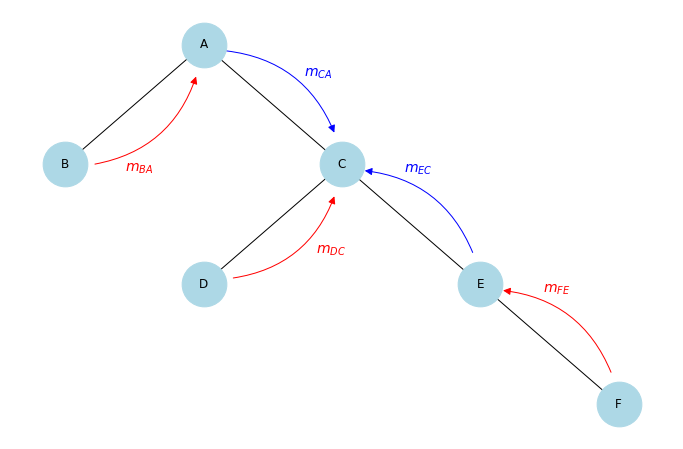

In [3]:
# Remove old message
a_ca.remove()

# Add new message arrow
arrow_start_ac = tuple(i + j for i,j in zip(positions["A"],(0.15, -0.05)))
arrow_end_ac = tuple(i + j for i,j in zip(positions["C"], (-0.05, 0.25)))
arrow_ac = patches.FancyArrowPatch(arrow_start_ac, arrow_end_ac, arrowstyle='-|>', mutation_scale=15, color='blue', connectionstyle="arc3,rad=-.3")

a_ac = ax.add_patch(arrow_ac)

# Remove old text
txt_ca.remove()

# Add new text
label_text_ac = Text(0.75 * (arrow_start_ac[0] + arrow_end_ac[0]), 0.55 * (arrow_start_ac[1] + arrow_end_ac[1]), "$m_{CA}$", color='blue', ha='center', va='center', size=14)
txt_ac = ax.add_artist(label_text_ac)

# Show plot
fig

Therefore, to calculate the marginal probability of some random variable in a tree-structured MRF, we simply find the normalized product of its incoming messages
\begin{align*}
    p(x_j) &= \frac{1}{Z} \prod_{i \in \mathcal{N}_j} m_{ij}(x_j), \text{ where } m_{ij}(x_j) = \sum_{x_i} \psi_{ij}(x_i,x_j) \prod_{k \in \mathcal{N}_i \backslash j} m_{ki}(x_i)
\end{align*}
but with the trick of pre-computing the messages (for both directions of an edge). This can be done either using
1. **depth-first update**: with one node arbitrarily serving as the root node, messages are passed from leaves to the root then to the leaves, or
2. **parallel update**: every node sends outgoing messages at each step after receiving incoming messages. This is the method demonstrated in the figures above showing the computation of $p(A)$ and $p(C)$.

#### Applying evidence
If we have observed values to any of the nodes, the process simplifies. The node with the observed value will be the **first** to send out messages, which will instantiate messages for other hidden nodes. This first message will simply be a sum over the potential multiplied by the "collapsed" probability/likelihood for the observed value. For example, if we have binary random variables and observed $x_i = 0$, then the "collapsed" probability is just $p(X_i=0) = 1$, $p(X_i=1) = 0$ and the outgoing message is
\begin{align*}
    & &m_{ij}(x_j) &= \sum_{x_i} \psi_{ij}(x_i,x_j) p(x_i) \\
    & & &= \psi_{ij}(0, x_j) p(0) + \psi_{ij}(1, x_j) p(1) \\
    \text{(expressed in vector form)} & & &= \begin{bmatrix} \psi_{ij}(0, 0) & \psi_{ij}(1, 0) \\ \psi_{ij}(0, 1) & \psi_{ij}(1, 1) \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix}.
\end{align*}

Additionally, because we now have evidence, the marginal probability should be written as a (marginalized) conditional probability (although nothing changes in practice):
\begin{align*}
    p(x_j \mid \mathcal{Z}) &= \frac{1}{Z} \prod_{i \in \mathcal{N}_j} m_{ij}(x_j).
\end{align*}

### Vector form
The standard practice in doing belief propagation is to use vectors and matrices, which requires an adjustment to the marginalization equation. The messages &mdash; now vectors &mdash; have to be combined using element-wise multiplication (a.k.a. the _Hadamard product_).
\begin{align*}
    p(x_j) &= \frac{1}{Z} \bigodot_{i \in \mathcal{N}_j} m_{ij}(x_j) \\
    &= \frac{1}{Z} \big( m_{1j} \odot m_{2j} \odot \ldots \odot m_{|\mathcal{N}_i| j} \big) \\
    &= \frac{1}{Z}
    \begin{bmatrix}
        m_{1, 1j} \\ \vdots \\ m_{D, 1j}
    \end{bmatrix} \odot
    \begin{bmatrix}
        m_{1, 2j} \\ \vdots \\ m_{D, 2j}
    \end{bmatrix} \odot \ldots \odot
    \begin{bmatrix}
        m_{1, |\mathcal{N}_i| j} \\ \vdots \\ m_{D, |\mathcal{N}_i| j}
    \end{bmatrix} \\
    &= \frac{1}{Z}
    \begin{bmatrix}
        m_{1, 1j} m_{1, 2j} \ldots m_{1, |\mathcal{N}_i| j} \\
        \vdots \\
        m_{D, 1j} m_{D, 2j} \ldots m_{D, |\mathcal{N}_i| j}
    \end{bmatrix}
\end{align*}

### Adaptation to pairwise MRFs
The belief propagation equation is frequently represented for pairwise MRFs where an additional potential is used, called the _unary potential_ $\phi_{i}(x_i)$
\begin{align*}
    p(x_j) &= \frac{1}{Z} \phi_j(x_j) \prod_{i \in \mathcal{N}_j} m_{ij}(x_j), \text{ where } m_{ij}(x_j) = \sum_{x_i} \psi_{ij}(x_i,x_j) \phi_i(x_i) \prod_{k \in \mathcal{N}_i \backslash j} m_{ki}(x_i).
\end{align*}

At its core, the unary potential is no different than any regular potentials (like the one we used above). The usage of the terms _unary_ (and _pairwise_) potentials is related to the representation of hidden Markov models (HMMs) using pairwise MRFs. In an HMM &mdash; where you have observable nodes $O$ (evidence variables) and hidden nodes $X$ (latent variables) &mdash; each observable node is only connected to its corresponding hidden node, while hidden nodes are usually also connected to other hidden nodes.

Unary potentials are then the potentials _between an observable node and a hidden one_, while pairwise potentials are potentials _between two hidden nodes_. While typical potentials have two arguments (because they are defined for an edge), a unary potential would only have one because the evidence node populates the second argument with the observed value:
\begin{align*}
    \phi_j(x_j) &\equiv \phi_j(x_j, o_j).
\end{align*}

If we consider the nodes B, D, and F in our previous MRF to be the observed variables with the remaining nodes as hidden variables, we have ourselves a pairwise MRF, as shown in the figure below. The observed nodes are in gray and node F is "folded" to the left to emphasize the typical visualization of pairwise MRFs. You can see that the two representations are equivalent.

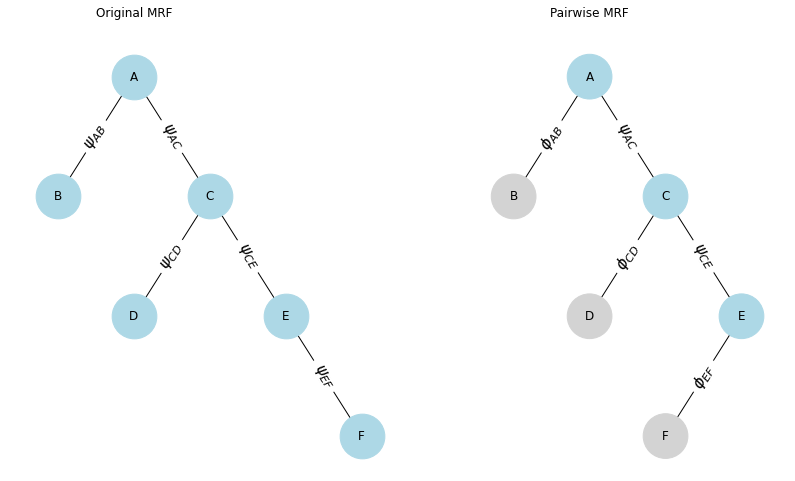

In [4]:
# Create an empty graph
G_original = nx.Graph()
G_pairwise = nx.Graph()

# Define node positions manually
positions_original = {"A": (-4, 2), "B": (-5, 1), "C": (-3, 1), "D": (-4, 0), "E": (-2, 0), "F": (-1, -1)}
positions_pairwise = {node: (coord[0]+6, coord[1]) for node, coord in positions_original.items()}
positions_pairwise["F"] = (3, -1) # fold the node to follow the pairwise MRF structure

# Add nodes
G_original.add_nodes_from(positions_original)
G_pairwise.add_nodes_from(positions_pairwise)

# Add edges
edges = [("A", "B"), ("A", "C"), ("C", "D"), ("C", "E"), ("E", "F")]
G_original.add_edges_from(edges)
G_pairwise.add_edges_from(edges)

edge_labels_original = {
    ("A", "B"): "$\psi_{AB}$",
    ("A", "C"): "$\psi_{AC}$",
    ("C", "D"): "$\psi_{CD}$",
    ("C", "E"): "$\psi_{CE}$",
    ("E", "F"): "$\psi_{EF}$",
}
edge_labels_pairwise = {
    ("A", "B"): "$\phi_{AB}$",
    ("A", "C"): "$\psi_{AC}$",
    ("C", "D"): "$\phi_{CD}$",
    ("C", "E"): "$\psi_{CE}$",
    ("E", "F"): "$\phi_{EF}$",
}

# Draw the graph
fig, ax = plt.subplots(figsize=(14, 8))
node_colors_pairwise = [
    "lightblue", "lightgray",
    "lightblue", "lightgray",
    "lightblue", "lightgray"
]

nx.draw(G_original, pos=positions_original, with_labels=True, node_size=2000, node_color="lightblue", ax=ax)
nx.draw(G_pairwise, pos=positions_pairwise, with_labels=True, node_size=2000, node_color=node_colors_pairwise, ax=ax)
nx.draw_networkx_edge_labels(G_original, pos=positions_original, edge_labels=edge_labels_original, font_color="black", font_size="16")
nx.draw_networkx_edge_labels(G_pairwise, pos=positions_pairwise, edge_labels=edge_labels_pairwise, font_color="black", font_size="16")

# Add titles/labels above each graph
plt.text(-4, 2.5, "Original MRF", fontsize=12, ha="center")
plt.text(2, 2.5, "Pairwise MRF", fontsize=12, ha="center")

plt.axis("off")  # Turn off axis labels
plt.show()

Therefore, after a closer look, both the marginalization equations are equivalent:
\begin{align*}
    p_{reg}(x_j) = \frac{1}{Z} \prod_{i \in \mathcal{N}_j} m_{ij, reg}(x_j) &\equiv \frac{1}{Z} \phi_j(x_j) \prod_{i \in \mathcal{N}_j} m_{ij, pair}(x_j) = p_{pair}(x_j)
\end{align*}
where
\begin{align*}
    m_{ij, reg}(x_j) = \sum_{x_i} \psi_{ij}(x_i,x_j) \prod_{k \in \mathcal{N}_i \backslash j} m_{ki}(x_i) &\equiv \sum_{x_i} \psi_{ij}(x_i,x_j) \phi_i(x_i) \prod_{k \in \mathcal{N}_i \backslash j} m_{ki}(x_i) = m_{ij, pair}(x_j)
\end{align*}
which means the belief propagation steps we discussed above apply to both representations.

Since pairwise MRFs are typically used for representing HMMs, a more precise expression that takes into account evidence nodes is
\begin{align*}
    p(x_j \mid \mathcal{Z}) &= \frac{1}{Z} \phi_j(x_j) \prod_{i \in \mathcal{N}_j} m_{ij}(x_j)
\end{align*}
but, as discussed previously, there is no effect on the execution of the algorithm whatsoever.

## Belief Propagation Example
### Scenario
Taken from [Alice Gao's lecture on Hidden Markov Models](https://cs.uwaterloo.ca/~a23gao/cs486686_f21/lecture_notes/Lecture_14_on_Hidden_Markov_Models_1.pdf):
> You are a security guard stationed at a secret underground installation. Every day, you want to know whether it’s raining or not. Unfortunately, your only access to the outside world is when you see the director brings or does not bring an umbrella each morning.

We further make some simplifying assumptions about the world: the previous day's state has a fixed transition probability to the next day and satisfies the Markov assumption. This gives us the following hidden Markov model (HMM): the director's umbrella is our observation $O$ to the hidden state of the world $S$. $S$ is a binary variable that indicates if it's raining and $O$ is a binary variable that indicates if we see the director with the umbrella.

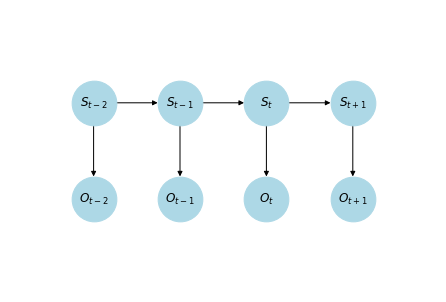

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G_bp_1 = nx.DiGraph()

# Define node positions manually
hidden_pos = {"$S_{t-2}$": (-2, 0), "$S_{t-1}$": (-1, 0), "$S_{t}$": (0, 0), "$S_{t+1}$": (1, 0)}
observed_pos = {"$O_{t-2}$": (-2, -1), "$O_{t-1}$": (-1, -1), "$O_{t}$": (0, -1), "$O_{t+1}$": (1, -1)}
positions = {**hidden_pos, **observed_pos}

# Add nodes
G_bp_1.add_nodes_from(hidden_pos)

# Add edges
edges = [("$S_{t-2}$", "$S_{t-1}$"), ("$S_{t-1}$", "$S_{t}$"), ("$S_{t}$", "$S_{t+1}$"),
         ("$S_{t-2}$", "$O_{t-2}$"), ("$S_{t-1}$", "$O_{t-1}$"), ("$S_{t}$", "$O_{t}$"), ("$S_{t+1}$", "$O_{t+1}$")]
G_bp_1.add_edges_from(edges)

# Draw the graph
nx.draw(G_bp_1, pos=positions, with_labels=True, node_size=2000, node_color="lightblue")
axis = plt.gca()
axis.set_xlim([-3, 2])
axis.set_ylim([-2, 1])
plt.axis("off")  # Turn off axis labels
plt.show()

<!-- CSS styling -->
<style>
    .centered-table {
        display: flex !important;
        justify-content: center;
    }
</style>

The state transition probabilities from the previous day to the current is given as follows.

<div class="centered-table">

| $S_t$ | False | True |
| --- | --- | --- |
| $P(S_t \mid S_{t-1} = \text{False})$ | 0.7 | 0.3 |
| $P(S_t \mid S_{t-1} = \text{True})$ | 0.3 | 0.7 |

</div>

Because the director may sometimes forget to bring an umbrella or preemptively carry one, the observation of the state is not deterministic. Hence, the observation model is described as follows.

<div class="centered-table">

| $O_t$ | False | True |
| --- | --- | --- |
| $P(O_t \mid S_t = \text{False})$ | 0.8 | 0.2 |
| $P(O_t \mid S_t = \text{True})$ | 0.1 | 0.9 |

</div>

These are essentially the potentials (pairwise: $\psi_{{t-1},t}(S_{t-1}, S_{t})$ and unary: $\phi_{t}(S_t, O_t)$) in a pairwise Markov Random Field (MRF), which the graph shown below.

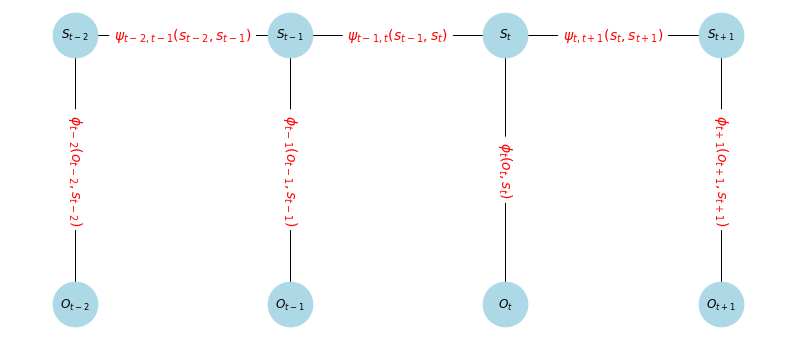

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G_bp_2 = nx.Graph()

# Define node positions manually
hidden_pos = {"$S_{t-2}$": (-12, 0), "$S_{t-1}$": (-6, 0), "$S_{t}$": (0, 0), "$S_{t+1}$": (6, 0)}
observed_pos = {"$O_{t-2}$": (-12, -4), "$O_{t-1}$": (-6, -4), "$O_{t}$": (0, -4), "$O_{t+1}$": (6, -4)}
positions = {**hidden_pos, **observed_pos}

# Add nodes
G_bp_2.add_nodes_from(positions)

# Add edges
edges = [("$S_{t-2}$", "$S_{t-1}$"), ("$S_{t-1}$", "$S_{t}$"), ("$S_{t}$", "$S_{t+1}$"),
         ("$S_{t-2}$", "$O_{t-2}$"), ("$S_{t-1}$", "$O_{t-1}$"), ("$S_{t}$", "$O_{t}$"), ("$S_{t+1}$", "$O_{t+1}$")]
G_bp_2.add_edges_from(edges)
edge_labels = {
    ("$S_{t-2}$", "$S_{t-1}$"): "$\psi_{t-2,t-1}(s_{t-2}, s_{t-1})$",
    ("$S_{t-1}$", "$S_{t}$"): "$\psi_{t-1,t}(s_{t-1}, s_{t})$",
    ("$S_{t}$", "$S_{t+1}$"): "$\psi_{t,t+1}(s_{t}, s_{t+1})$",
    ("$S_{t-2}$", "$O_{t-2}$"): "$\phi_{t-2}(o_{t-2}, s_{t-2})$",
    ("$S_{t-1}$", "$O_{t-1}$"): "$\phi_{t-1}(o_{t-1}, s_{t-1})$",
    ("$S_{t}$", "$O_{t}$"): "$\phi_{t}(o_{t}, s_{t})$",
    ("$S_{t+1}$", "$O_{t+1}$"): "$\phi_{t+1}(o_{t+1}, s_{t+1})$"
}

# Draw the graph
fig, ax = plt.subplots(figsize=(14, 6))
nx.draw(G_bp_2, pos=positions, with_labels=True, node_size=2000, node_color="lightblue")
nx.draw_networkx_edge_labels(G_bp_2, pos=positions, edge_labels=edge_labels, font_color='red', font_size=14)
plt.axis("off")  # Turn off axis labels
plt.show()

Now, we can use belief propagation to do inference. Let's consider the quer:
1. What is the probability that it is actually raining outside after observing umbrellas yesterday and today, _i.e._, $P(S_{t}=\text{True} \mid O_{t}=\text{True}, O_{t-1}=\text{True})$?
2. What is the probability that it we wouldn't see the director with an umbrella today after seeing the director with the umbrella yesterday and if he brings it tomorrow, _i.e._, $P(O_{t}=\text{False} \mid O_{t-1}=\text{True}, O_{t+1}=\text{True})$?

Their corresponding MRFs would look like the following with gray nodes indicating observed variables.

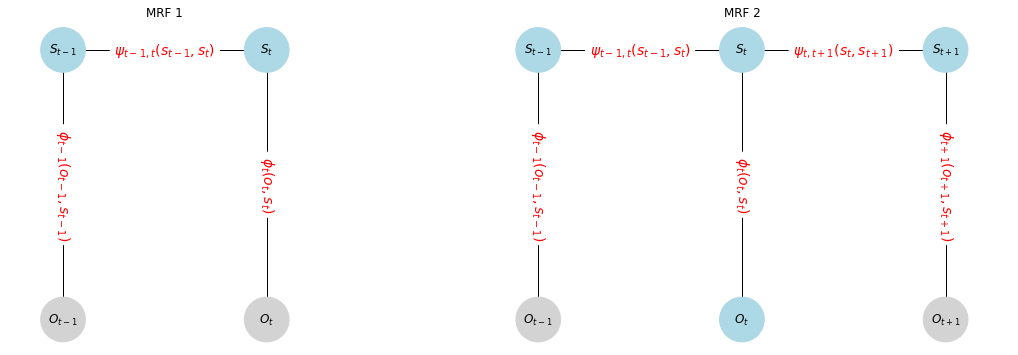

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G_bp_q1 = nx.Graph()
G_bp_q2 = nx.Graph()

# Define node positions manually
hidden_pos_1 = {"$S_{t-1}$": (-6, 0), "$S_{t}$": (0, 0)}
observed_pos_1 = {"$O_{t-1}$": (-6, -4), "$O_{t}$": (0, -4)}
positions_1 = {**hidden_pos_1, **observed_pos_1}

hidden_pos_2 = {"$S_{t-1}$": (8, 0), "$S_{t}$": (14, 0), "$S_{t+1}$": (20, 0), "$O_{t}$": (14, -4)}
observed_pos_2 = {"$O_{t-1}$": (8, -4), "$O_{t+1}$": (20, -4)}
positions_2 = {**hidden_pos_2, **observed_pos_2}

# Add nodes
G_bp_q1.add_nodes_from(positions_1)
G_bp_q2.add_nodes_from(positions_2)

# Add edges
edges_1 = [("$S_{t-1}$", "$S_{t}$"),
           ("$S_{t-1}$", "$O_{t-1}$"), ("$S_{t}$", "$O_{t}$")]
G_bp_q1.add_edges_from(edges_1)
edge_labels_1 = {
    ("$S_{t-1}$", "$S_{t}$"): "$\psi_{t-1,t}(s_{t-1}, s_{t})$",
    ("$S_{t-1}$", "$O_{t-1}$"): "$\phi_{t-1}(o_{t-1}, s_{t-1})$",
    ("$S_{t}$", "$O_{t}$"): "$\phi_{t}(o_{t}, s_{t})$"
}

edges_2 = [("$S_{t-1}$", "$S_{t}$"), ("$S_{t}$", "$S_{t+1}$"),
           ("$S_{t-1}$", "$O_{t-1}$"), ("$S_{t}$", "$O_{t}$"), ("$S_{t+1}$", "$O_{t+1}$")]
G_bp_q2.add_edges_from(edges_2)
edge_labels_2 = {
    ("$S_{t-1}$", "$S_{t}$"): "$\psi_{t-1,t}(s_{t-1}, s_{t})$",
    ("$S_{t}$", "$S_{t+1}$"): "$\psi_{t,t+1}(s_{t}, s_{t+1})$",
    ("$S_{t-1}$", "$O_{t-1}$"): "$\phi_{t-1}(o_{t-1}, s_{t-1})$",
    ("$S_{t}$", "$O_{t}$"): "$\phi_{t}(o_{t}, s_{t})$",
    ("$S_{t+1}$", "$O_{t+1}$"): "$\phi_{t+1}(o_{t+1}, s_{t+1})$"
}

# Draw the graph
fig, ax = plt.subplots(figsize=(18, 6))
node_colors_1 = ["lightblue" if node in hidden_pos_1 else "lightgray" for node in G_bp_q1.nodes]
nx.draw(G_bp_q1, pos=positions_1, with_labels=True, node_size=2000, node_color=node_colors_1)
nx.draw_networkx_edge_labels(G_bp_q1, pos=positions_1, edge_labels=edge_labels_1, font_color='red', font_size=14)

node_colors_2 = ["lightblue" if node in hidden_pos_2 else "lightgray" for node in G_bp_q2.nodes]
nx.draw(G_bp_q2, pos=positions_2, with_labels=True, node_size=2000, node_color=node_colors_2)
nx.draw_networkx_edge_labels(G_bp_q2, pos=positions_2, edge_labels=edge_labels_2, font_color='red', font_size=14)

# Add titles/labels above each graph
plt.text(-3, 0.5, "MRF 1", fontsize=12, ha="center")
plt.text(14, 0.5, "MRF 2", fontsize=12, ha="center")

plt.axis("off")  # Turn off axis labels
plt.show()

### Solution Sketch
The main idea in inference is to find the posterior probability (a.k.a. the belief) given some evidence. We start by precomputing the messages; the starting node(s) are those which we can initialize with the evidence (typically the leaf nodes).

We need to make two passes, from the leaf nodes to the root node, then back to the leaf nodes again in order to cover all the messages in the tree.

Before proceeding, we convert the probability tables (potentials) into matrices. The first index is for $\text{False}$ and the second index is for $\text{True}$, going from left to right and top to bottom.

\begin{align*}
    P(S_{t} \mid S_{t-1}) &= 
        \begin{bmatrix}
            0.7 & 0.3 \\
            0.3 & 0.7
        \end{bmatrix},\,
    P(O_{t} \mid S_{t}) &= 
        \begin{bmatrix}
            0.8 & 0.2 \\
            0.1 & 0.9
        \end{bmatrix}.
\end{align*}

We can also obtain $P(S_{t-1} \mid S_{t})$ as $P(S_{t} \mid S_{t-1})$ by considering a uniform prior for both $S_{t-1}$ and $S_t$ using Bayes rule
\begin{align*}
    P(S_{t} \mid S_{t-1}) P(S_{t-1}) &= P(S_{t-1} \mid S_{t}) P(S_{t}).
\end{align*}

The same can also be applied to $P(S_{t} \mid O_{t})$:
\begin{align*}
    P(S_{t} \mid O_{t}) P(O_{t}) &= P(O_{t} \mid S_{t}) P(S_{t}).
\end{align*}

Once we have all the messages precomputed, the marginal distribution is simply a normalized product of all the messages.

### Query 1: $P(S_{t}=\text{True} \mid O_{t}=\text{True}, O_{t-1}=\text{True})$
There actually isn't a need to precompute all the messages since we only have one query, but let's assume that we care about marginalizing over other hidden states too.

1. Precompute messages from $O_{t-1}$ to $S_{t-1}$ and from $O_{t}$ to node $S_{t}$.

    \begin{align*}
        m_{O_{t-1},S_{t-1}}(S_{t-1}) &= \sum_{o_{t-1}} \phi_{t-1}(O_{t-1}, S_{t-1}) P(O_{t-1}) \\
        &= P(O_{t-1} \mid S_{t-1}) P(O_{t-1}) \\
        &= P(\text{True} \mid S_{t-1}) P(\text{True}) \\
        &=
        \begin{bmatrix}
            0.8 & 0.2 \\
            0.1 & 0.9 
        \end{bmatrix}
        \begin{bmatrix}
            0 \\
            1
        \end{bmatrix} \\
        &=
        \begin{bmatrix}
            0.2 \\
            0.9
        \end{bmatrix}.
    \end{align*}

    This is also the result for $m_{O_{t},S_{t}}$ since the values are identical.

2. Precompute messages from $S_{t-1}$ to ${S_t}$ and vice versa.

    \begin{align*}
        m_{S_{t-1},S_{t}}(S_t) &= \sum_{s_{t-1}} \psi_{t-1, t}(S_{t-1}, S_{t}) m_{O_{t-1}, S_{t-1}}(S_{t-1}) \\
        &= P(S_{t} \mid S_{t-1}) m_{O_{t-1}, S_{t-1}}(S_{t-1}) \\
        &=
        \begin{bmatrix}
            0.7 & 0.3 \\
            0.3 & 0.7 
        \end{bmatrix}
        \begin{bmatrix}
            0.2 \\
            0.9
        \end{bmatrix} \\
        &=
        \begin{bmatrix}
            0.41 \\
            0.69
        \end{bmatrix}.
    \end{align*}

    This is also the result for $m_{S_{t},S_{t-1}}$ since the values are identical.

3. Compute the (marginal) conditional probability.

    \begin{align*}
        & & P&(S_{t}=\text{True} \mid O_{t}=\text{True}, O_{t-1}=\text{True}) \\
        \text{(original MRF notation)}& & &= \frac{1}{Z} \prod_{j \in \eta(i)} m_{ji}(x_i) = \frac{1}{Z} m_{O_t,St}(S_t) \odot m_{S_{t-1}, S_t}(S_t)
        = \frac{1}{Z}
        \begin{bmatrix}
            0.2 \\
            0.9
        \end{bmatrix} \odot
        \begin{bmatrix}
            0.41 \\
            0.69
        \end{bmatrix}
        = \frac{1}{Z}
        \begin{bmatrix}
            0.082 \\
            0.621
        \end{bmatrix}
        =
        \begin{bmatrix}
            0.1166 \\
            0.8834
        \end{bmatrix} \\
        \text{(pairwise MRF notation)} & & &= \frac{1}{Z} \phi_{i}(x_i) \prod_{j \in \eta(i)} m_{ji}(x_i)
        = \frac{1}{Z} p(S_t \mid O_t=\text{True} ) \odot m_{S_{t-1}, S_t}(S_t)
        = \frac{1}{Z}
        \begin{bmatrix}
            0.2 \\
            0.9 
        \end{bmatrix} \odot
        \begin{bmatrix}
            0.41 \\
            0.69
        \end{bmatrix}
        = \frac{1}{Z}
        \begin{bmatrix}
            0.082 \\
            0.621
        \end{bmatrix}
        =
        \begin{bmatrix}
            0.1166 \\
            0.8834
        \end{bmatrix}
    \end{align*}

    The result tells us that it is highly likely (88.34%) that it is raining today given that the director has brought umbrellas yesterday and today. This makes sense because both the state transition and observation probabilities have a "momentum" associated with the matching states. The states are likely to remain the same between consecutive days (70%), while the observation is quite accurate and reports the correct observation with a high probability (80%). 

### Query 2: finding $P(O_{t}=\text{False} \mid O_{t}=\text{True}, O_{t+1}=\text{True})$

1. Precompute messages from $O_{t-1}$ to $S_{t-1}$ and from $O_{t+1}$ to node $S_{t+1}$.

    \begin{align*}
        m_{O_{t-1},S_{t-1}}(S_{t-1}) &= \sum_{o_{t-1}} \phi_{t-1}(O_{t-1}, S_{t-1}) P(O_{t-1}) \\
        &= P(O_{t-1} \mid S_{t-1}) P(O_{t-1}) \\
        &= P(\text{True} \mid S_{t-1}) P(\text{True}) \\
        &=
        \begin{bmatrix}
            0.8 & 0.2 \\
            0.1 & 0.9 
        \end{bmatrix}
        \begin{bmatrix}
            0 \\
            1
        \end{bmatrix} \\
        &=
        \begin{bmatrix}
            0.2 \\
            0.9
        \end{bmatrix}.
    \end{align*}

    This is also the result for $m_{O_{t+1},S_{t+1}}$ since the values are identical.

2. Precompute messages from $S_{t-1}$ to $S_{t}$ and from $S_{t+1}$ to $S_{t}$.

    \begin{align*}
        m_{S_{t-1},S_{t}}(S_{t}) &= \sum_{s_{t-1}} \psi_{t-1, t}(S_{t-1}, S_{t}) m_{O_{t-1}, S_{t-1}}(S_{t-1}) \\
        &= P(S_{t} \mid S_{t-1}) m_{O_{t-1}, S_{t-1}}(S_{t-1}) \\
        &=
        \begin{bmatrix}
            0.7 & 0.3 \\
            0.3 & 0.7 
        \end{bmatrix}
        \begin{bmatrix}
            0.2 \\
            0.9
        \end{bmatrix} \\
        &=
        \begin{bmatrix}
            0.41 \\
            0.69
        \end{bmatrix}.
    \end{align*}

    This is also the result for $m_{S_{t+1},S_{t}}$ since the values are identical.
    
3. Precompute the message from $S_{t}$ to $O_{t}$.

    \begin{align*}
        m_{S_{t}, O_{t}}(O_{t}) &= \sum_{s_{t}} \phi_{t, t}(S_{t}, O_{t}) m_{S_{t-1}, S_{t}}(S_{t}) m_{S_{t+1}, S_{t}}(S_{t}) \\
        &= P(S_{t} \mid O_{t}) ( m_{S_{t-1}, S_{t}}(S_{t}) \odot m_{S_{t}, S_{t+1}}(S_{t+1}) ) \\
        &=
        \begin{bmatrix}
            0.8 & 0.2 \\
            0.1 & 0.9 
        \end{bmatrix}
        \begin{bmatrix}
            0.41^2 \\
            0.69^2
        \end{bmatrix} \\
        &=
        \begin{bmatrix}
            0.2297 \\
            0.4453
        \end{bmatrix}.
    \end{align*}

4. Compute the (marginal) conditional probability.

    \begin{align*}
        P(S_{t}=\text{True} \mid O_{t}=\text{True}, O_{t+1}=\text{True}) &= \frac{1}{Z} \prod_{j \in \eta(i)} m_{ji}(x_i) \\
        &= \frac{1}{Z} m_{S_{t}, O_{t}}(O_{t}) \\
        &= \frac{1}{Z}
        \begin{bmatrix}
            0.2297 \\
            0.4453
        \end{bmatrix} \\
        &=
        \begin{bmatrix}
            0.3403 \\
            0.6597
        \end{bmatrix}
    \end{align*}

The result tells us that it is quite unlikely that we would see the director without an umbrella today if we were to see one yesterday and tomorrow, which is expected based on the explanation given in the answer to the previous query.